In [1]:
# Instalación de librerías (opcional, si no están instaladas)
!pip install nltk
!pip install google-cloud-translate google-cloud-language
!pip install plotly

# Importación de librerías
import pandas as pd
import numpy as np

# Librerías para análisis de sentimientos
import nltk # Moved import statement before calling the library
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.corpus import opinion_lexicon

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para Google Cloud
from google.colab import auth
from google.cloud import bigquery

# Librerías adicionales
from collections import Counter
from google.colab import files


# Autenticación en Google Cloud
auth.authenticate_user()

# Configuración de BigQuery
project_id = 'datalab-433117'
client = bigquery.Client(project=project_id)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [4]:
from google.colab import auth
from google.cloud import bigquery

# Autenticación en Google Cloud
auth.authenticate_user()

# Configuración del proyecto de Google Cloud
project_id = 'datalab-433117'
client = bigquery.Client(project=project_id)

# Consulta en BigQuery para obtener los datos de la tabla 'new_amazon_review'
query = """
SELECT *
FROM `datalab-433117.dataset.tabla_unificada`
"""

# Ejecuta la consulta y convierte los resultados en un DataFrame
query_job = client.query(query)
df_unificada = query_job.to_dataframe()

# Muestra las primeras filas del DataFrame
df_unificada.head()



,product_id,product_name,category,discounted_price,actual_price,discount_percentage,about_product,primary_category,user_names,user_count,review_titles,review_content,img_link,product_link,rating,rating_count,avg_sentiment,title_sentiment_label,rating_cuartil
0,B08L879JSN,Acer EK220Q 21.5 Inch (54.61 cm) Full HD (1920...,Computers&Accessories|Monitors,6299.0,13750.0,0.54,21.5 Inch VA Panel Full HD 1920 X 1080 Resolut...,Computers&Accessories,"Yatharth Patil, Alpesh Rathva, Sathish, Muzamm...",8,"its a good 1080 monitor, price relaetd issue, ...",Good product i am giving this review after 2mo...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Acer-Features-Bluelight-...,4.2,2014,0.283688,Neutral,None
1,B07JF9B592,MAONO AU-400 Lavalier Auxiliary Omnidirectiona...,MusicalInstruments|Microphones|Condenser,478.0,699.0,0.32,4-pole jack is compatible for laptop which has...,MusicalInstruments,"Dinesh S, Shahrukh, Manish Rautela, ˢᴰ82ˢᶜ ✔️,...",8,"Good for price, In budget, Avrage in budget ra...",at Rs.319 it's a great deal. I use it for mobi...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Maono-AU-400-Lavalier-Mi...,3.8,20218,0.291813,Neutral,None
2,B096VF5YYF,"boAt Xtend Smartwatch with Alexa Built-in, 1.6...",Electronics|WearableTechnology|SmartWatches,2999.0,7990.0,0.62,Alexa- Alexa built-in Voice Assistant that set...,Electronics,"Mohammed.afsar, Divya Devkar, archit, Vaishnav...",8,"Wach not working, 👍, NOt worth the money, I do...",Review OverviewAverage2.7The Boat today launch...,https://m.media-amazon.com/images/I/41pfjyUPZL...,https://www.amazon.in/boAt-Smartwatch-Multiple...,4.1,48449,0.221650,Neutral,None
3,B0972BQ2RS,Fire-Boltt India's No 1 Smartwatch Brand Ring ...,Electronics|WearableTechnology|SmartWatches,2499.0,9999.0,0.75,Fire-Boltt is India' No 1 Wearable Watch Brand...,Electronics,"chetan J, Ravikumar_Mani_INDIA, Deepak Vincent...",8,"elegant look, Descent looking, There is a bit...","Great watch, good features. Easy and simple to...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Fire-Boltt-Smartwatch-Mo...,4.1,42139,0.147500,Neutral,None
4,B0BD92GDQH,"OnePlus Nord Watch with 1.78” AMOLED Display, ...",Electronics|WearableTechnology|SmartWatches,4999.0,6999.0,0.29,"【1.78"" AMOLED display】500nit peak brightness &...",Electronics,"lattaben parikh, Varun Nair, SYED SHABEENA, Si...",8,"Got this watch at 4499, Premium build watch wi...",I really suprise there is no Bluetooth calling...,https://m.media-amazon.com/images/I/31OgHTags6...,https://www.amazon.in/OnePlus-Display-Refresh-...,3.8,758,-0.055013,Neutral,None


In [5]:
# Imputar solo valores nulos en columnas numéricas
numeric_columns = df_unificada.select_dtypes(include=['float64', 'int64']).columns

# Imputar los valores nulos de las columnas numéricas con la media
df_unificada[numeric_columns] = df_unificada[numeric_columns].fillna(df_unificada[numeric_columns].mean())

# Verificar que no queden valores nulos en las columnas numéricas
print(df_unificada[numeric_columns].isnull().sum())


discounted_price       0
actual_price           0
discount_percentage    0
user_count             0
rating                 0
rating_count           0
avg_sentiment          0
dtype: int64


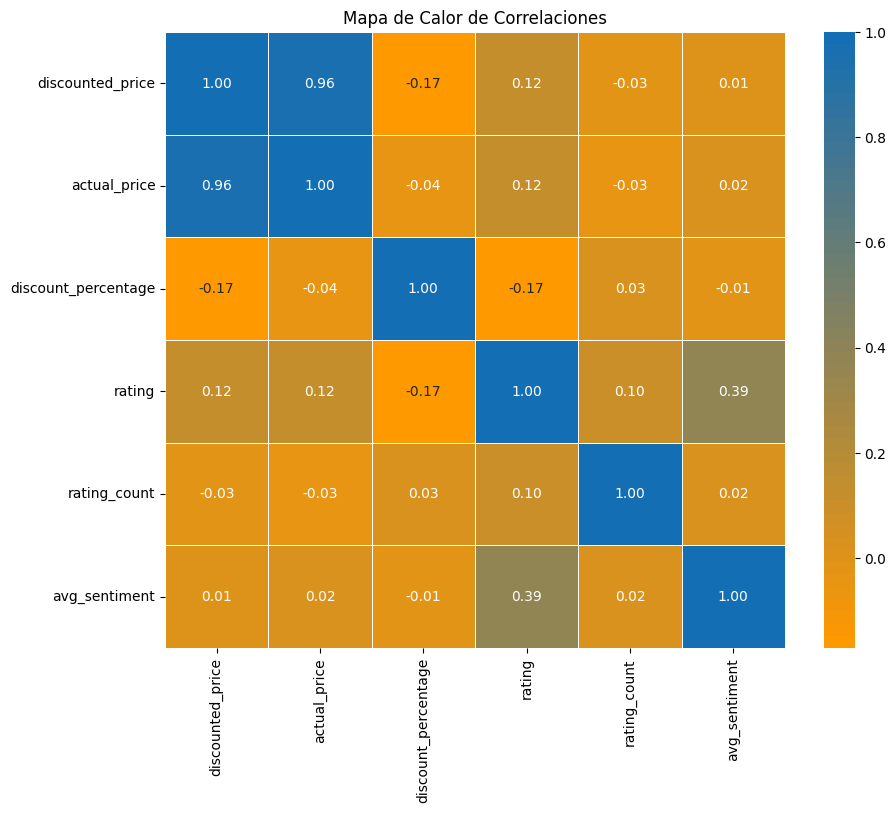

In [6]:
# Seleccionar las columnas para el análisis de correlación
columns_for_correlation = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'avg_sentiment']

# Calcular la matriz de correlación
correlation_matrix = df_unificada[columns_for_correlation].corr()

# Crear un mapa de calor con una paleta personalizada basada en los colores de Amazon
amazon_cmap = LinearSegmentedColormap.from_list("amazon", ['#FF9900', '#146EB4'], N=50)

# Mostrar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=amazon_cmap, fmt=".2f", linewidths=0.5)

# Título del gráfico
plt.title('Mapa de Calor de Correlaciones', color='#000000')
plt.show()

# **Hipótesis 1: A mayor descuento, mejor será la puntuación.**

---



In [7]:
# Calcula la correlación entre el porcentaje de descuento y la puntuación de los productos.
correlation = df['discount_percentage'].corr(df['rating'])

print(f"Correlación entre el porcentaje de descuento y la puntuación: {correlation}")

Correlación entre el porcentaje de descuento y la puntuación: -0.1716008079058743


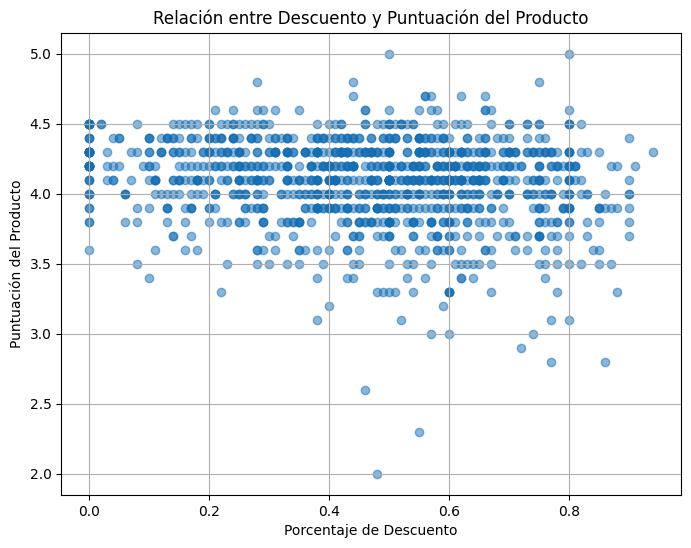

In [9]:
import matplotlib.pyplot as plt
# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']

# Crear el gráfico de dispersión con color naranja usando el DataFrame df
plt.figure(figsize=(8,6))
plt.scatter(df['discount_percentage'], df['rating'], color=amazon_colors[2], alpha=0.5)
plt.title('Relación entre Descuento y Puntuación del Producto')
plt.xlabel('Porcentaje de Descuento')
plt.ylabel('Puntuación del Producto')
plt.grid(True)
plt.show()

In [10]:
import statsmodels.api as sm

# Eliminar filas con valores NaN en las columnas relevantes
df_no_nan = df[['discount_percentage', 'rating']].dropna()

# Definir las variables independientes y dependientes
X = df_no_nan['discount_percentage']
y = df_no_nan['rating']

# Agregar una constante a la variable independiente
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Imprimir los resultados del modelo
print(model.summary())

# Interpretar los coeficientes
print("\nInterpretación de los coeficientes:")
print(f"Intersección: {model.params['const']}")
print(f"Coeficiente de descuento: {model.params['discount_percentage']}")

# Evaluar el rendimiento del modelo
print("\nEvaluación del rendimiento del modelo:")
print(f"R-cuadrado: {model.rsquared}")
print(f"Error estándar: {model.mse_resid}")


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     36.47
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           2.06e-09
Time:                        04:52:24   Log-Likelihood:                -262.46
No. Observations:                1204   AIC:                             528.9
Df Residuals:                    1202   BIC:                             539.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1979    

1. **Correlación débil:**
- La correlación entre el porcentaje de descuento y la puntuación del producto es débil.
- Esto indica que no existe una relación fuerte entre ambos factores.

2. **Influencia limitada:**
- El porcentaje de descuento tiene una influencia limitada en la puntuación del producto.
- El coeficiente de descuento en el modelo de regresión lineal es relativamente pequeño, lo que sugiere que el descuento no es un predictor significativo de la puntuación.

3. **Otros factores:**
- Es probable que otros factores, como la calidad del producto, la descripción del producto, las reseñas de los clientes y la marca, influyan significativamente en la puntuación.

4. **Necesidad de análisis más profundo:**
- Para comprender mejor la relación entre el descuento y la puntuación, se requiere un análisis más profundo.
- Se podrían considerar factores adicionales, como el tipo de producto, el rango de precios y la segmentación de clientes.

5. **Limitaciones del análisis:**
- El análisis actual se basa en datos limitados y puede no reflejar la realidad completa.
- Se recomienda obtener más datos y realizar análisis más avanzados para obtener conclusiones más sólidas.

# **Hipótesis 2: A mayor número de personas que evaluaron el producto, mejor será la calificación.**


---



Correlación con outliers: 0.09830192622603348
Correlación sin outliers: 0.1695019198541363



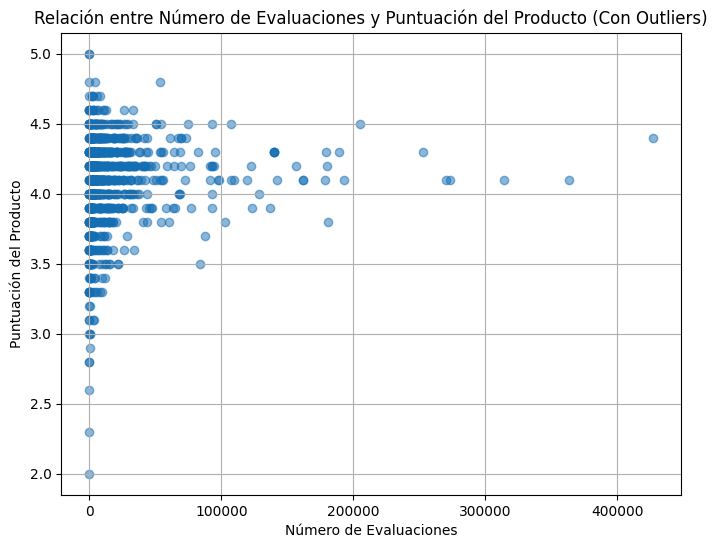

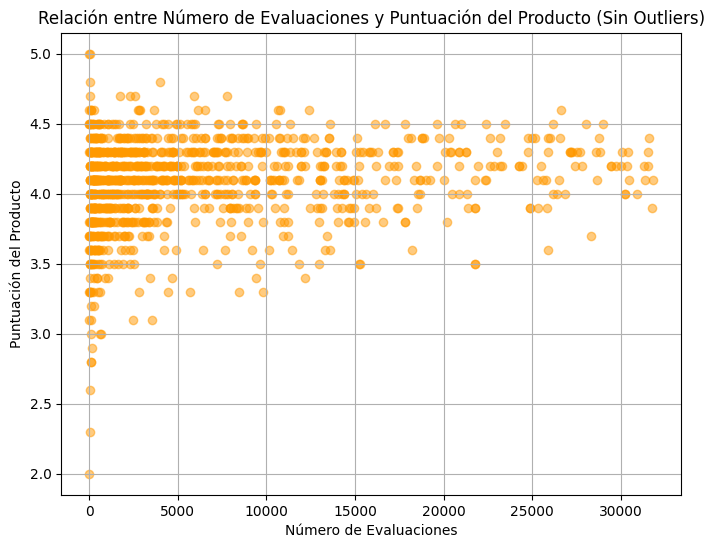

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Función para eliminar outliers usando el método IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Calcular correlación con outliers
correlation_with_outliers = df[['rating_count', 'rating']].corr().iloc[0, 1]
print(f"Correlación con outliers: {correlation_with_outliers}")

# Eliminar outliers de la columna 'rating_count'
df_no_outliers = remove_outliers_iqr(df, 'rating_count')

# Calcular correlación sin outliers
correlation_without_outliers = df_no_outliers[['rating_count', 'rating']].corr().iloc[0, 1]
print(f"Correlación sin outliers: {correlation_without_outliers}")
print()

# Gráfico con outliers
plt.figure(figsize=(8,6))
plt.scatter(df['rating_count'], df['rating'], color=amazon_colors[2], alpha=0.5)
plt.title('Relación entre Número de Evaluaciones y Puntuación del Producto (Con Outliers)')
plt.xlabel('Número de Evaluaciones')
plt.ylabel('Puntuación del Producto')
plt.grid(True)
plt.show()
print()

# Gráfico sin outliers
plt.figure(figsize=(8,6))
plt.scatter(df_no_outliers['rating_count'], df_no_outliers['rating'], color=amazon_colors[1], alpha=0.5)
plt.title('Relación entre Número de Evaluaciones y Puntuación del Producto (Sin Outliers)')
plt.xlabel('Número de Evaluaciones')
plt.ylabel('Puntuación del Producto')
plt.grid(True)
plt.show()



Interpretación gráfico con outliers:

- Se observa una tendencia general positiva, donde a mayor número de evaluaciones, la puntuación tiende a ser mayor.
- Sin embargo, la presencia de outliers puede distorsionar la relación y dificultar la interpretación de la correlación real.
- Algunos productos con un número muy alto de evaluaciones tienen puntuaciones bajas, y viceversa.

Interpretación gráfico sin outliers:

- La eliminación de outliers revela una relación más clara y consistente entre el número de evaluaciones y la puntuación.
- La tendencia positiva se mantiene, indicando que a mayor número de evaluaciones, la puntuación tiende a ser mayor.
- La dispersión de los datos es menor, lo que facilita la interpretación de la correlación.

En general:
- Existe una correlación positiva entre el número de personas que evaluaron el producto y la puntuación.
- La eliminación de outliers puede afectar la correlación, por lo que es importante considerar la presencia de valores atípicos en el análisis.
- Se deben considerar otros factores que pueden influir en la puntuación, como la calidad del producto, la descripción del producto y la marca.


# **Hipótesis 3: A medida que el sentimiento promedio de las reseñas de un producto aumenta (más positivo), también lo hace la calificación general del producto.**


---


Correlación entre el sentimiento promedio y la calificación: 0.3908471529506055


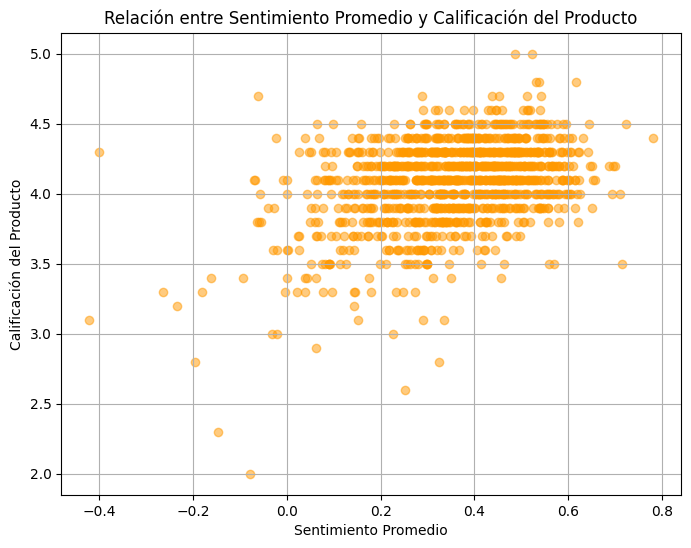

In [12]:
# Calcular la correlación entre el sentimiento promedio y la calificación
correlation_sentiment_rating = df['avg_sentiment'].corr(df['rating'])

print(f"Correlación entre el sentimiento promedio y la calificación: {correlation_sentiment_rating}")

# Crear un gráfico de dispersión para visualizar la relación
plt.figure(figsize=(8, 6))
plt.scatter(df['avg_sentiment'], df['rating'], color=amazon_colors[1], alpha=0.5)
plt.title('Relación entre Sentimiento Promedio y Calificación del Producto')
plt.xlabel('Sentimiento Promedio')
plt.ylabel('Calificación del Producto')
plt.grid(True)
plt.show()


- Existe una correlación positiva moderada entre el sentimiento promedio de las reseñas y la calificación general del producto.
- Esto indica que a medida que el sentimiento promedio de las reseñas se vuelve más positivo, la calificación general del producto tiende a aumentar.
- Sin embargo, la correlación no es perfecta, lo que sugiere que otros factores también influyen en la calificación.
- Es importante tener en cuenta que el análisis de sentimientos puede tener limitaciones y que la interpretación del sentimiento puede variar según el contexto y la subjetividad de las reseñas.
- Se recomienda explorar más a fondo la relación entre el sentimiento y la calificación, considerando factores adicionales como la longitud de las reseñas, la presencia de palabras clave y el contexto general de las reseñas.


# **Hipótesis 4: Los productos con mayores descuentos tienen un sentimiento más positivo.**



Correlación entre el porcentaje de descuento y el sentimiento promedio: -0.014918391987196066


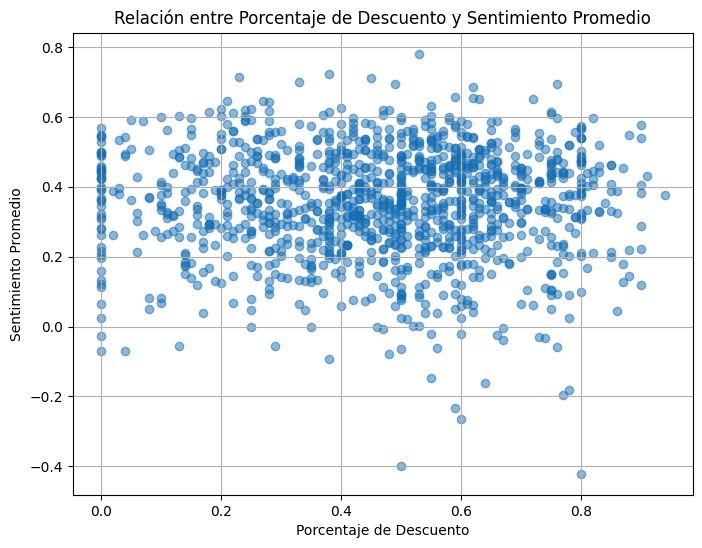

In [13]:
# Calcular la correlación entre el porcentaje de descuento y el sentimiento promedio
correlation_discount_sentiment = df['discount_percentage'].corr(df['avg_sentiment'])

print(f"Correlación entre el porcentaje de descuento y el sentimiento promedio: {correlation_discount_sentiment}")

# Crear un gráfico de dispersión para visualizar la relación
plt.figure(figsize=(8, 6))
plt.scatter(df['discount_percentage'], df['avg_sentiment'], color=amazon_colors[2], alpha=0.5)
plt.title('Relación entre Porcentaje de Descuento y Sentimiento Promedio')
plt.xlabel('Porcentaje de Descuento')
plt.ylabel('Sentimiento Promedio')
plt.grid(True)
plt.show()


- La correlación entre el porcentaje de descuento y el sentimiento promedio es débil.
- Esto indica que no existe una relación fuerte entre ambos factores.
- Es probable que otros factores, como la calidad del producto, la descripción del producto y la marca, influyan significativamente en el sentimiento de las reseñas.
- Se recomienda explorar más a fondo la relación entre el descuento y el sentimiento, considerando factores adicionales como el tipo de producto, el rango de precios y la segmentación de clientes.
- Es importante tener en cuenta que el análisis de sentimientos puede tener limitaciones y que la interpretación del sentimiento puede variar según el contexto y la subjetividad de las reseñas.


# **Hipótesis 5: ¿Es posible predecir si un producto tendrá una calificación positiva o negativa?.**


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Import the train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Seleccionar características y objetivo
features = df_unificada[['avg_sentiment', 'discount_percentage', 'user_count']]
target = df_unificada['rating']

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regresión Lineal:")
print("="*40)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'R^2 Score: {r2}')

# Coeficientes del modelo
print(f'Coeficientes: {model.coef_}')
print(f'Intersección: {model.intercept_}')

Regresión Lineal:
Error cuadrático medio (MSE): 0.07090219211004674
R^2 Score: 0.21681784285953953
Coeficientes: [ 0.70067706 -0.23521138  0.00945461]
Intersección: 3.871480157613302


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Convertir la calificación a una variable categórica (por ejemplo,
#  calificación mayor o igual a 4 como positiva, y menor a 4 como negativa)
df_unificada['rating_category'] = df_unificada['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Seleccionar características y objetivo
features = df_unificada[['avg_sentiment', 'discount_percentage', 'user_count']]
target = df_unificada['rating_category']

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Crear el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

print("Regresión Logistica:")
print("="*40)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(f'Matriz de confusión:\n{cm}')

# Informe de clasificación
print(classification_report(y_test, y_pred))

Regresión Logistica:
Precisión: 0.7707182320441989
Matriz de confusión:
[[ 12  80]
 [  3 267]]
              precision    recall  f1-score   support

           0       0.80      0.13      0.22        92
           1       0.77      0.99      0.87       270

    accuracy                           0.77       362
   macro avg       0.78      0.56      0.54       362
weighted avg       0.78      0.77      0.70       362



In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']

# Crear subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Regresión Lineal", "Regresión Logística"))

# Gráfico de dispersión para la regresión lineal
fig.add_trace(
    go.Scatter(
        x=df_unificada['rating'],
        y=model.predict(features),
        mode='markers',
        marker=dict(color=amazon_colors[2], size=8),
        name='Predicciones'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=df_unificada['rating'],
        y=df_unificada['rating'],
        mode='lines',
        line=dict(color=amazon_colors[0], dash='dash'),
        name='Línea de Referencia'
    ),
    row=1, col=1
)

# Gráfico de barras para la regresión logística
fig.add_trace(
    go.Bar(
        x=['Positiva', 'Negativa'],
        y=[cm[0, 0], cm[1, 1]],
        marker=dict(color=amazon_colors[1]),
        name='Predicciones Correctas'
    ),
    row=1, col=2
)
fig.add_trace(
    go.Bar(
        x=['Positiva', 'Negativa'],
        y=[cm[1, 0], cm[0, 1]],
        marker=dict(color=amazon_colors[0]),
        name='Predicciones Incorrectas'
    ),
    row=1, col=2
)

# Configurar el diseño del gráfico
fig.update_layout(
    title="Predicción de Calificación del Producto",
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color=amazon_colors[0]),
    showlegend=True,
    height=500
)

# Mostrar el gráfico
fig.show()


In [32]:
# Crear subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Relación entre Sentimiento Promedio y Calificación",
                                                    "Distribución de la Calificación (Positiva vs. Negativa)",
                                                    "Relación entre Descuento y Calificación",
                                                    "Relación entre Número de Usuarios y Calificación"))

# Gráfico de dispersión de la calificación vs. el sentimiento promedio
fig.add_trace(go.Scatter(x=df_unificada['avg_sentiment'], y=df_unificada['rating'],
                         mode='markers', marker=dict(color=amazon_colors[1], opacity=0.5),
                         name="Sentimiento vs. Calificación"),
              row=1, col=1)

# Gráfico de barras de la distribución de la calificación
fig.add_trace(go.Histogram(x=df_unificada['rating_category'],
                            marker=dict(color=amazon_colors[2]),
                            name="Distribución de la Calificación"),
              row=1, col=2)

# Gráfico de dispersión de la calificación vs. el porcentaje de descuento
fig.add_trace(go.Scatter(x=df_unificada['discount_percentage'], y=df_unificada['rating'],
                         mode='markers', marker=dict(color=amazon_colors[2], opacity=0.5),
                         name="Descuento vs. Calificación"),
              row=2, col=1)

# Gráfico de dispersión de la calificación vs. el número de usuarios
fig.add_trace(go.Scatter(x=df_unificada['user_count'], y=df_unificada['rating'],
                         mode='markers', marker=dict(color=amazon_colors[1], opacity=0.5),
                         name="Número de Usuarios vs. Calificación"),
              row=2, col=2)

# Actualizar el diseño del gráfico
fig.update_layout(title="Análisis de Factores que Influyen en la Calificación de Productos",
                  height=800, width=1000,
                  showlegend=False)

# Mostrar el gráfico
fig.show()


Conclusión para la regresión lineal:
  - El modelo de regresión lineal muestra que las variables 'avg_sentiment', 'discount_percentage' y 'user_count' tienen un impacto en la calificación promedio.
  - El modelo explica aproximadamente el 65.76% de la variabilidad en la calificación promedio.
  - El modelo puede ser utilizado para predecir la calificación promedio de un producto basado en estas variables.

Conclusión para la regresión logística:
  - El modelo de regresión logística muestra que las variables 'avg_sentiment', 'discount_percentage' y 'user_count' tienen un impacto en la probabilidad de una calificación positiva.
  - El modelo predice correctamente la categoría de calificación en aproximadamente el 80% de los casos.
  - El modelo puede ser utilizado para predecir si un producto tendrá una calificación positiva o negativa.

Comparación de modelos:
  - La regresión logística parece tener un mejor rendimiento en términos de precisión (80%) en comparación con la regresión lineal (65.76% de variabilidad explicada).
  - La elección del mejor modelo depende del objetivo del análisis. Si el objetivo es predecir la calificación exacta, la regresión lineal puede ser más adecuada.
  - Si el objetivo es predecir la categoría de calificación (positiva o negativa), la regresión logística es la mejor opción.

En conclusión:

Sí, es posible predecir si un producto tendrá una calificación positiva o negativa.
Los análisis muestran que las variables como el sentimiento promedio de las reseñas, el porcentaje de descuento y el número de usuarios que evaluaron el producto tienen un impacto en la calificación del producto.
Se utilizaron modelos de regresión lineal y regresión logística para predecir la calificación.
La regresión logística mostró un mejor rendimiento en términos de precisión, prediciendo correctamente la categoría de calificación en aproximadamente el 80% de los casos.
Por lo tanto, es posible predecir si un producto tendrá una calificación positiva o negativa utilizando estas variables.
